In [16]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
path_before = '../data/przed_operacja/out_nerka_Moving2_SPLINE.mhd'
path_after = '../data/po/out_nerka_Moving2_SPLINE.mhd'

image_before = sitk.ReadImage(path_before, sitk.sitkFloat32)
image_after = sitk.ReadImage(path_after, sitk.sitkFloat32)

In [3]:
path_seg_before = '../data/przed_operacja/TOTAL.mhd'
path_seg_after = '../data/po/TOTAL.mhd'

seg_before = sitk.ReadImage(path_seg_before)
seg_after = sitk.ReadImage(path_seg_after)

In [4]:
viewer = sitk.ImageViewer()
# ! this is for MacOS only, change it for your OS
command = '/Applications/Slicer.app/Contents/MacOS/Slicer'
viewer.SetCommand(command)

In [5]:
viewer.Execute(sitk.LabelOverlay(image_after, seg_after))

### Breakdown after operation

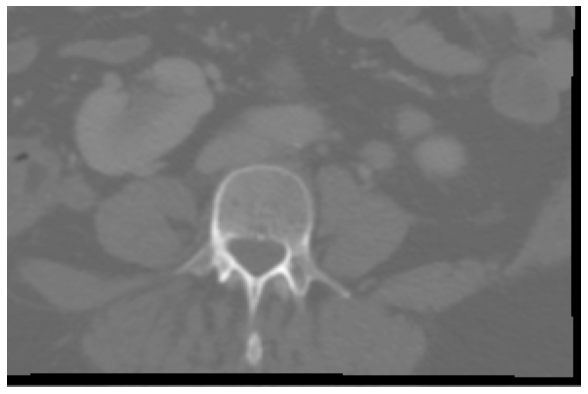

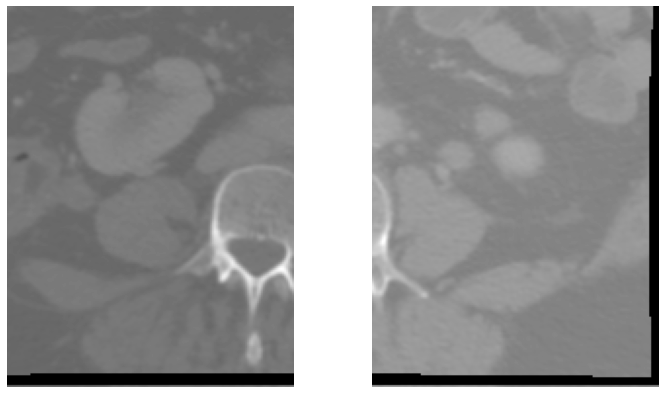

In [12]:
after_arr = sitk.GetArrayFromImage(image_after)
plt.figure(figsize=(12,7))
plt.imshow(after_arr[70], cmap='gray')
plt.axis('off')
plt.show()

half = after_arr.shape[2] // 2

left_after = after_arr[:,:,:half]
right_after = after_arr[:,:,half:]

seg_after_arr = sitk.GetArrayFromImage(seg_after)
left_seg_after = seg_after_arr[:,:,:half]
right_seg_after = seg_after_arr[:,:,half:]

plot, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].imshow(left_after[70], cmap='gray')
ax[0].axis('off')
ax[1].imshow(right_after[70], cmap='gray')
ax[1].axis('off')
plt.show()

#### Voxel method (based on segmentation)

In [7]:
def voxels_volume(sitk_image, seg_slices):
    voxels = 0
    voxel_volume = 1

    for spacing in sitk_image.GetSpacing():
        voxel_volume *= spacing

    for seg_slice in seg_slices:
        # 1 stands for kindey
        values, counts = np.unique(seg_slice, return_counts=True)
        val_dict = dict(zip(values, counts))
        
        try:
            voxels +=  val_dict[1]
        except KeyError:
            pass
    
    volume = voxels * voxel_volume
    return volume


In [8]:
voxels_volume(image_after, left_seg_after)

113404.65467553

In [9]:
voxels_volume(image_after, right_seg_after)

126186.51861806399

#### Elipsoid method

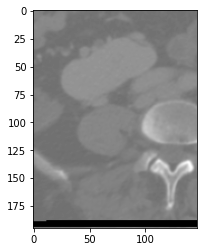

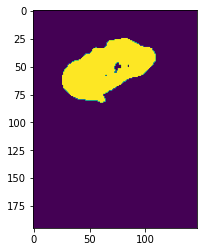

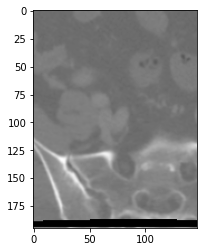

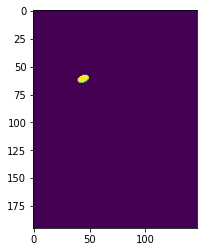

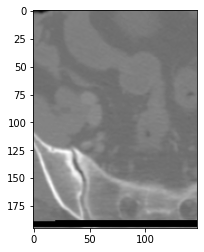

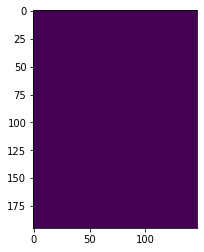

In [15]:
max_idx = None
first_idx = 158
last_idx = 0
max_counts = 0

for idx, seg_slice in enumerate(left_seg_after):
    mask = seg_slice == 1
    _, counts = np.unique(mask, return_counts=True)
    if len(counts) > 1 and counts[1] > max_counts:
        max_counts = counts[1]
        max_idx = idx
        if idx < first_idx:
            first_idx = idx
        if idx > max_idx:
            last_idx = idx

plt.imshow(left_after[max_idx, :, :], cmap='gray')
plt.show() 
plt.imshow(left_seg_after[max_idx, :, :] == 1)
plt.show()

plt.imshow(left_after[first_idx, :, :], cmap='gray')
plt.show()
plt.imshow(left_seg_after[first_idx, :, :] == 1)
plt.show()

plt.imshow(left_after[last_idx, :, :], cmap='gray')
plt.show()
plt.imshow(left_seg_after[last_idx, :, :] == 1)
plt.show()

In [31]:
max_left_seg = (left_seg_after[max_idx, :, :] == 1).astype(np.uint8)
max_left_seg *= 255
contour, hierarchy = cv.findContours(max_left_seg, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

(array([[[ 79,  25]],
 
        [[ 78,  26]],
 
        [[ 73,  26]],
 
        [[ 72,  27]],
 
        [[ 68,  27]],
 
        [[ 66,  29]],
 
        [[ 66,  31]],
 
        [[ 63,  34]],
 
        [[ 57,  34]],
 
        [[ 56,  33]],
 
        [[ 55,  34]],
 
        [[ 54,  34]],
 
        [[ 53,  35]],
 
        [[ 53,  36]],
 
        [[ 50,  39]],
 
        [[ 47,  39]],
 
        [[ 42,  44]],
 
        [[ 41,  44]],
 
        [[ 40,  45]],
 
        [[ 37,  45]],
 
        [[ 36,  46]],
 
        [[ 35,  46]],
 
        [[ 33,  48]],
 
        [[ 32,  48]],
 
        [[ 31,  49]],
 
        [[ 31,  50]],
 
        [[ 28,  53]],
 
        [[ 28,  54]],
 
        [[ 27,  55]],
 
        [[ 27,  57]],
 
        [[ 26,  58]],
 
        [[ 26,  66]],
 
        [[ 27,  67]],
 
        [[ 27,  69]],
 
        [[ 34,  76]],
 
        [[ 35,  76]],
 
        [[ 36,  77]],
 
        [[ 37,  77]],
 
        [[ 38,  78]],
 
        [[ 39,  78]],
 
        [[ 40,  79]],
 
        [[ 46,  

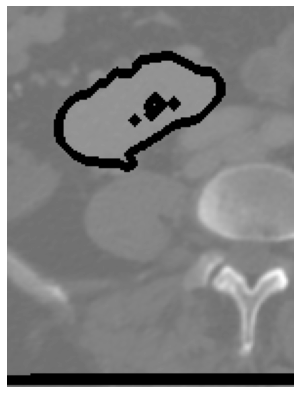

In [40]:
plt.figure(figsize=(12,7))
plt.axis('off')
plt.imshow(cv.drawContours(left_after[max_idx], contour, -1, (0, 255, 0), 3), cmap='gray')